## Обнаружение каверов музыкальных треков

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. 

### EDA 

Нам были представлена база данных о треках, состаящая из трех датасетов:

- `covers.json` содержит разметку каверов, сделанную редакторами сервиса;

- `meta.json` содержит метаинформацию о треках;

- `lyrics.json` содержит тексты песен.

Для начала переведем json формат в датафрейм:

In [1]:
import pandas as pd
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
def read_json(file_name:str):
    data = []

    # Открываем файл JSON для чтения
    with open(file_name, 'r') as file:
        for line in file:
            # Пытаемся разобрать каждую строку JSON и добавить ее в список
            try:
                obj = json.loads(line)
                data.append(obj)
            except json.JSONDecodeError:
                print(f"Ошибка при разборе строки: {line}")
    return pd.DataFrame(data)

covers = read_json('covers.json')
text = read_json('lyrics.json')
meta = read_json('meta.json')

### Covers

In [4]:
covers

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
...,...,...,...
71592,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,ORIGINAL
71593,None,78b2db35476f134dc3cdfbf4d77ba034,COVER
71594,None,e720ff378efe032df56e0e656a6a92d3,COVER
71595,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,ORIGINAL


In [5]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


Датафрейм `covers` содержит следующие данные:

- `track_id` - уникальный идентификатор трека;

- `track_remake_type` - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;

- `original_track_id` - уникальный идентификатор исходного трека.

Как видно из данных, столбец `original_track_id` имеет пропуски в данных.

Посмотрим, содержит ли датафрейм дубликаты:

In [6]:
covers.duplicated().sum()

0

Дубликатов нет, посмотрим, имеются ли одинаковые треки по столбцу `track_id`:

In [7]:
covers['track_id'].nunique()

71597

Все треки уникальные. Построим гистограмму распределения типов треков на кавер и оригинал:

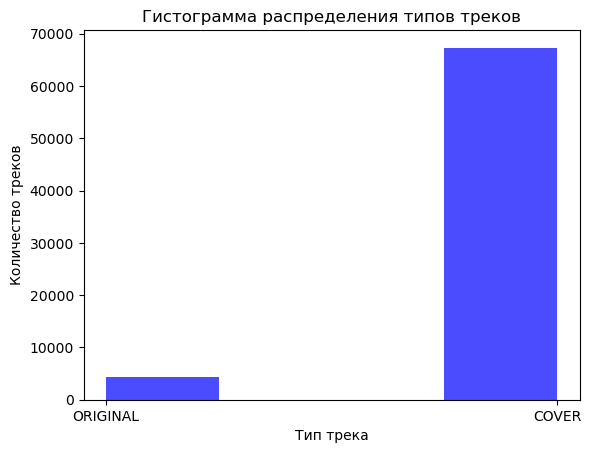

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64


In [8]:
plt.hist(covers['track_remake_type'], bins=4, color='blue', alpha=0.7)
plt.xlabel('Тип трека')
plt.ylabel('Количество треков')
plt.title('Гистограмма распределения типов треков')
plt.show()

print(covers['track_remake_type'].value_counts())

Как видим каверов датафрейм содежрит намного больше:

- количество каверов - 67304;
- количество оригиналов - 4293.

#### Краткий вывод

Датафрейм `covers` содержит уникальные значения `track_id` и `track_remake_type`, однако имеет пропуски в столбце `original_track_id`.

Тут может вставить мысль о заполнении пропусков...

### Text

Датафрейм `text` содержит следующие данные:

- `track_id` - уникальный идентификатор трека;

- `lyricId` - уникальный идентификатор текста;

- `text` - текст трека.

In [9]:
text

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659
...,...,...,...
11409,90522f12df92da5d585f8f6ec9bb34b5,All my little plans and schemes\nLost like som...,b734225e54122798535b40666e6e361e
11410,b82bd468c888ae17d2e976c8cf3b9d4c,I will make my way\nI'm trying to survive anot...,b3cbb82e4ef67e75b1e47054a681db86
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d
11412,0979b4049635e1c0fc161573f75ab23a,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d


In [10]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


Датафрейм `text` содежрит 11414 строк, не имеет пропусков и все значения типа object. Проверим, имеются ли дубликаты:

In [11]:
text.duplicated().sum()

0

### Краткий вывод

Датафрем `text` не содежрит дубликатов и имеет 11414 уникальных значений.

### Meta

Датафрейм `meta` содержит следующие данные:

- `track_id` - уникальный идентификатор трека;

- `dttm` - первая дата появления информации о треке;

- `title` - название трека;

- `language` - язык исполнения;

- `isrc` - международный уникальный идентификатор трека;

- `genres` - жанры;

- `duration` - длительность трека;

In [12]:
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
...,...,...,...,...,...,...,...
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,[INDIE],212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0


In [13]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


Датафрейм содержит 71768 строк, сразу видно, что столбцы `language` и `isrc` имеют пропуски, также столбец даты `dttm` имеет нечитабельный формат данных. 

In [14]:
meta.isnull().sum()

track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          1
duration        1
dtype: int64

In [15]:
meta.dropna(inplace=True,axis=0)
meta['dttm'] = meta['dttm'].div(1000).apply(lambda x: datetime.fromtimestamp(x))

Функция убирает все пропуски, в том числе и в столбцах `language` и `isrc`. Если мы их заполняем, то это нужно поставить перед этой функцией. 

In [16]:
meta

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-17 00:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 17:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
18,55a4890cc667212a048ce81b4049d1ea,2021-11-24 19:59:05,Tacones Rojos,ES,GBKPL2174553,"[POP, FOLK, LATINFOLK]",181230.0
25,94093810e71074bec5a6990c1c214165,2022-10-20 00:00:00,Humsafar,HI,GX3HH2123738,[FOLK],153690.0
26,2b74d8dc05d365e51cf4ff2bcc9727f0,2021-12-10 00:00:00,Die Together,EN,QZS672179786,[DANCE],177190.0
...,...,...,...,...,...,...,...
71762,495babc700c0c6b5b8549d49f163d3cb,2021-07-04 00:00:00,Stay With Me,EN,GBKPL1955058,"[JAZZ, VOCALJAZZ]",152090.0
71764,4be93dea1715e54db86aaa7f7e9bfb10,2019-06-13 08:20:09,Chanceuse,FR,CAISO1800023,[INDIE],212690.0
71766,26b6aca1c6a02ad0e2a939164716657e,2019-06-13 20:50:02,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0
71767,d904dda141238e6ad1b428bfbb21262d,2019-06-13 20:50:02,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0


In [26]:
print(meta['dttm'].min())
print(meta['dttm'].max())

2009-08-10 21:32:06
2023-10-18 00:00:00


Дату исправили. Посмотрим на распределение данных:

In [32]:
meta['track_id'].nunique()

21964

Все значения `track_id` уникальны, что с названиями треков:

In [33]:
meta['title'].value_counts()

Smooth Criminal            53
Wicked Game                45
Smells Like Teen Spirit    35
Toxic                      32
Baby One More Time         28
                           ..
Quick Death in Texas        1
Brain Stew                  1
Carolina Drama              1
Everything We Need          1
17                          1
Name: title, Length: 16288, dtype: int64

В названиях имеются повторы, но если `track_id` уникальны, то вероятно тут сидят и каверы.

Text(0.5, 1.0, 'Гистограмма распределения треков по языкам')

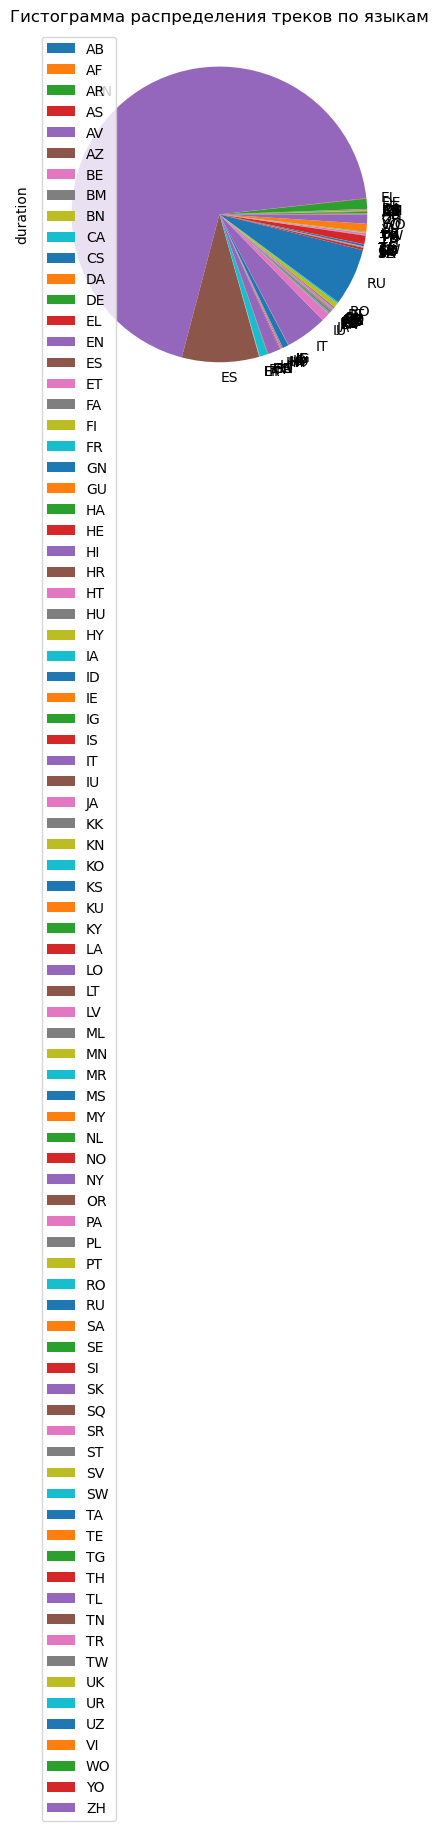

In [34]:
meta.groupby(['language']).sum().plot(kind='pie', subplots=True)
plt.title('Гистограмма распределения треков по языкам')

In [35]:
meta['language'].value_counts()

EN    15322
ES     1747
RU     1553
IT      907
HI      285
      ...  
BM        1
TN        1
AB        1
NY        1
IU        1
Name: language, Length: 85, dtype: int64

Как видим, большую часть данных составляют англоязычные треки, далее идут испаноязычные и русскоязычные.

In [36]:
meta['genres'].value_counts()

[POP]                                               5742
[ROCK, ALLROCK]                                     2049
[DANCE]                                             1357
[FOLK, LATINFOLK]                                   1081
[ELECTRONICS]                                       1070
                                                    ... 
[SPIRITUAL, NEWAGE, ELECTRONICS]                       1
[CLASSICAL, NEWAGE, ELECTRONICS, CLASSICALMUSIC]       1
[REGGAE, SKA]                                          1
[ROCK, ELECTRONICS, ALLROCK]                           1
[ROCK, ALLROCK, FOLKGENRE]                             1
Name: genres, Length: 210, dtype: int64

Самым популярным жанром оказался `POP`, далее идет `ROCK` и `DANCE`. Причем имеются многожанровые треки, поэтому и разброс уникальных значений столь велик.

In [37]:
meta['isrc'].nunique()

21933

Повторы имеются и в столбце `isrc`

In [39]:
meta['isrc'].value_counts()

QZGWX2002100    2
GBAFQ0700594    2
QZNC62100542    2
QZGWW2040131    2
USAT29901394    2
               ..
QZGWX2217144    1
QZGWX2217143    1
QZGWX2217142    1
QZGWX2217141    1
FR59R1921791    1
Name: isrc, Length: 21933, dtype: int64

Наглядно видны повторы... Если `isrc` - международный уникальный идентификатор трека, а `track_id` - уникальный идентификатор трека, то как может быть, что у нас все значения `track_id` уникальны, а значения `isrc` повторяются???

Столбец `duration` показывает длительноть треков:

In [45]:
print(f"Медианная длительность трека составляет", meta['duration'].median())

Медианная длительность трека составляет 202320.0


In [46]:
print(f"Средняя длительность трека составляет", meta['duration'].mean())

Средняя длительность трека составляет 204612.5840921508
